In [2]:
from utils.plot_line import plot_line_graph
from utils.normalize import normalize
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Variables by month plus PCA'}, xlabel='date', ylabel='Normalized variables [-5, 5]'>)

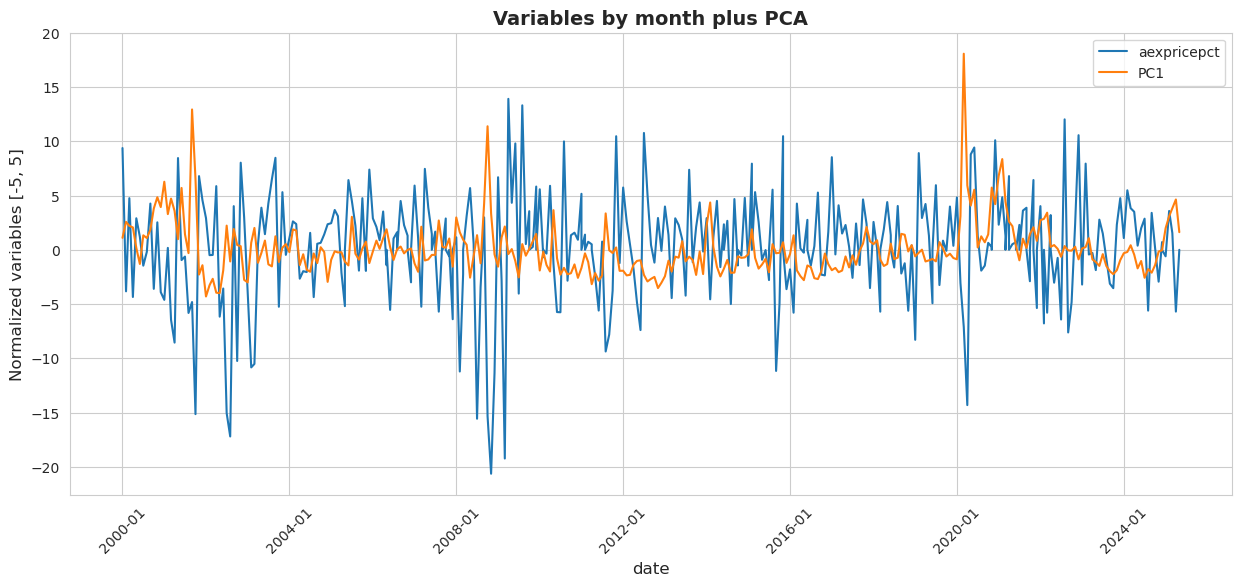

In [ ]:
cs_df = pd.read_csv('consumersentiment/consumer_sentiment_pca.csv')
google_df= pd.read_csv('googletrends/googletrends_pca_output.csv')
vaex_df= pd.read_csv('vaex/investing.comVAEXmonthly.csv')
ipo_df= pd.read_csv('ipo/euronextIPOAms.csv')
ed_df= pd.read_csv('debtequityissues/monthlyequitytodebtratio.csv')
to_df = pd.read_csv('marketbasedindicators/turnover.csv')
div_df = pd.read_csv('marketbasedindicators/dividendpremium.csv')


aexprice_df = pd.read_csv('aex_maandelijks.csv')

for df in [cs_df, google_df, vaex_df, ipo_df, ed_df, to_df, aexprice_df, div_df]:
    df['date'] = pd.to_datetime(df['date'])

# vaex_df['date'] = pd.to_datetime(vaex_df['date'], format='%m/%d/%Y')
    
ipo_df = ipo_df[["ipo_count", "date"]]

merged_df = pd.merge(cs_df, google_df, on='date', how='outer')
merged_df = pd.merge(merged_df, ipo_df, on='date', how='outer')
merged_df = pd.merge(merged_df, vaex_df, on='date', how='outer')
merged_df = pd.merge(merged_df, ed_df, on='date', how='outer')
merged_df = pd.merge(merged_df, to_df, on='date', how='outer')
merged_df = pd.merge(merged_df, div_df, on='date', how='outer')

merged_df = pd.merge(merged_df, aexprice_df, on='date', how='outer')
merged_df.set_index('date', inplace=True)

merged_df = merged_df.drop(columns=['Change', 'Open', 'High', 'Low', 'Debt', 'Equity', 'Unknown', 'total_shares', 'Unnamed: 0'])

count_col = merged_df['ipo_count']
price_col = merged_df["vaex_price"]

columns_to_plot = ["Dividend Premium", "detrended_turnover", "Equity-to-Debt Ratio", "ipo_count", "googletrends_pca", "consumer_sentiment_pca"]

imputer = SimpleImputer(strategy='mean')
cols_to_impute = merged_df.columns.difference(['ipo_count'])
merged_df[cols_to_impute] = imputer.fit_transform(merged_df[cols_to_impute])

merged_df['ipo_count'] = count_col.fillna(0)

scaler = StandardScaler()
merged_df[[f"{col}_norm" for col in columns_to_plot]] = scaler.fit_transform(merged_df[columns_to_plot])
X_scaled = scaler.fit_transform(merged_df)

pca = PCA(n_components=1)
first_pc = pca.fit_transform(X_scaled)

df_pc1 = pd.DataFrame(first_pc, columns=['PC1'])

df_pc1.index = merged_df.index
merged_df['PC1'] = df_pc1['PC1']

# merged_df = normalize(merged_df, 'vaex_price')
# merged_df = normalize(merged_df, 'googletrends_pca')
# merged_df = normalize(merged_df, 'aexprice')

merged_df['aexpricepct'] = merged_df['aexprice'].pct_change() * 100
# print(merged_df)

merged_df = merged_df[merged_df.index >= pd.to_datetime('2000-01-01')]
merged_df.to_stata("final_df_plot.dta")

plot_line_graph(
            df=merged_df.reset_index(),
            x_column='date',
            # y_column=['consumer_sentiment_pca', 'normalized_googletrends_pca', 'aexprice','ipo_count','PC1', "Equity-to-Debt Ratio", 'detrended_turnover'],
            # y_column=['normalized_vaex_price'],
            # y_column=['detrended_turnover'],
            #  y_column=[f"{col}_norm" for col in columns_to_plot],
            # y_column=["Equity-to-Debt Ratio"],
            y_column=["aexpricepct","PC1"],
            title='Variables by month plus PCA',
            xlabel='date',
            ylabel='Normalized variables [-5, 5]',
            grid=True
)